# Solving the Travelling Salesman Problem using Genetic Algorithm

The *Traveling Salesman Problem* (TSP) is a classic and extremely important optimisation problem in the field of operations research and computer science. It can be stated as follows: *Given a set of cities and the distances between each pair of cities, the goal is to find the shortest possible route that visits each city exactly once and returns back to the starting city.* The TSP is known to be a NP-hard problem, hence it doesn't have a known polynomial-time algorithm which solves it exactly. In this first lab session, we will try to leverage *Genetic Algorithm* (GA) to come up with a solution.

Let's start by importing some useful modules.

In [1]:
import random
import numpy as np

We define a `City` class to handle our cities more easily. 

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __eq__(self, other_city):
        return isinstance(other_city, City) and self.x == other_city.x and self.y == other_city.y
    
    def __ne__(self, other_city):
        return not self == other_city
    
    def distance(self, city):
        x_diff = abs(self.x - city.x)
        y_diff = abs(self.y - city.y)
        return np.sqrt((x_diff ** 2) + (y_diff ** 2))

Now we want a function to initialize our population. Remember that each route must contain each city **exactly once**.

In [3]:
def get_cities(n_cities, x_range, y_range):
    cities = []
    for _ in range(0, n_cities):
        cities.append(City(x=int(random.random() * x_range), y=int(random.random() * y_range)))
    return cities

def init_population(cities, pop_size):
    return [random.sample(cities, len(cities)) for _ in range(0, pop_size)]

We define the **fitness** as the inverse of the route distance. Since we want to minimise the distance, we want to maximise our fitness score.

In [4]:
def fitness_score(route):
    total_distance = 0
    for i in range(0, len(route)):
        city1 = route[i]
        city2 = None
        if i + 1 < len(route):
            city2 = route[i + 1]
        else:
            city2 = route[0]
        total_distance += city1.distance(city2)
    return 1 / float(total_distance)

We define now a function to perform **tournament selection** (or any other selection strategy you may prefer).

In [5]:
def tournament_selection(pop, fit, k):
  tournament = random.choices(pop, k=k)
  selected = max([(fit(x), x) for x in tournament])
  return selected[1]

Since each individual is a permutation of a set of different cities we must ensure that crossover and mutation generate valid individuals. As for the crossover, we can choose between the **partially mapped crossover** (**PMX**) and the **cycle crossover**. Let's implement both.

In [6]:
def pmx(parent1, parent2):
    offspring = parent1[:]
    
    #Select randomly the 2 crossover points
    point1, point2 = random.sample(range(len(parent1)), 2)
    point1, point2 = min(point1, point2), max(point1, point2)
    
    #Perform the exchange
    for i in range(point1, point2+1):
        offspring[i] = parent2[i]

    #Fill the remaining positions to make the offspring valid
    for i in range(len(parent1)):
        if i < point1 or i > point2:
            while offspring[i] in offspring[point1:point2 + 1]:
                idx = offspring.index(offspring[i], point1, point2 + 1)
                offspring[i] = parent1[idx]
    return offspring


In [7]:
def cx(parent1, parent2):
    #The elements which are not visited by the cycle are the ones of the second parent
    offspring = parent2[:]
    visited = [False] * len(parent1)

    #Select a random starting point
    i = random.sample(range(len(parent1)), 1)[0]

    while not visited[i]:
        visited[i] = True
        i = parent2.index(parent1[i])
        offspring[i] = parent1[i]

    return offspring

Let's check if we did everything right with simple lists of integers

In [17]:
parent1 = [7, 2, 3, 1, 5, 4, 6]
parent2 = [2, 4, 5, 6, 1, 7, 3]


print(pmx(parent1, parent2))
print(cx(parent1, parent2))

[7, 2, 3, 6, 1, 4, 5]
[7, 2, 5, 6, 1, 4, 3]


Also the mutation needs to generate valid individuals.

In [25]:
def mutate(individual, p_m):
    for i in range(len(individual)):
        if(random.random() < p_m):
            swap_idx = int(random.random() * len(individual))
            city1 = individual[i]
            city2 = individual[swap_idx]
            individual[i] = city2
            individual[swap_idx] = city1
    return individual

Now we define the function `generation`, exploiting the the ones we defined before for:
- Selection
- Crossover
- Mutation

In [26]:
def generation(pop, fit, crossover, p_m, t_size, elitism=True, k_el=1):
  pop_size = len(pop)
  elite = []
  if elitism: #the best k_el individual are passed directly to the next generation
    sorted_pop = sorted(pop, key=lambda x:fit(x), reverse=True)
    elite+=sorted_pop[:k_el]
  selected = [tournament_selection(pop, fit, t_size) for _ in range(0, pop_size-len(elite))]
  pairs = zip(selected, selected[1:] + selected[0:1])
  offsprings = [crossover(*pair) for pair in pairs]
  return list(map(lambda x: mutate(x, p_m), offsprings)) + elite

We can define our GA for a given number of generations.

In [27]:
def get_best(pop, fit):
  return max([(fit(x), x) for x in pop])

In [28]:
def GA(cities, pop_size, n, fit, crossover, t_size = 10, n_gen = 200):
  p_m = 1/n
  pop = init_population(cities, pop_size)
  history = [get_best(pop, fit)[0]]
  for _ in range(0, n_gen):
    pop = generation(pop, fit, crossover, p_m, t_size)
    history.append(get_best(pop, fit)[0])
  return get_best(pop, fit), history

Run the Algorithm with different crossover startegies and parametrisations. For each experiment, make a line plot showing the best fitness score for each generation.

In [29]:
cities = get_cities(25, 200, 200)

In [30]:
res, history = GA(cities=cities, pop_size=41, n=len(cities), fit=fitness_score, crossover=pmx)
print(res[0])

0.001045315843021418


In [31]:
import matplotlib.pyplot as plt

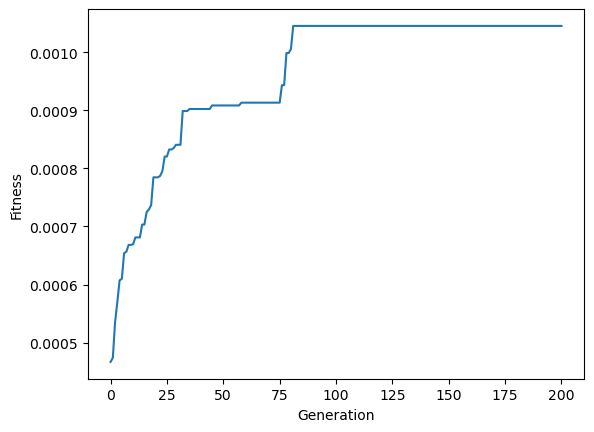

In [32]:
plt.plot(history)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.show()

Let's plot the solution found by the GA. 

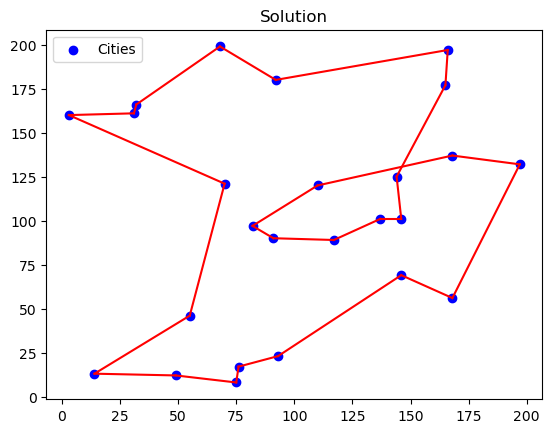

In [33]:
route = res[1]

x = [city.x for city in route]
y = [city.y for city in route]

plt.scatter(x, y, label='Cities', color='blue')

for i in range(len(cities) - 1):
    plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'r-')

plt.plot([x[len(cities)-1], x[0]], [y[len(cities)-1], y[0]], 'r-')
plt.title('Solution')

# Show legend
plt.legend()

# Show the plot
plt.show()